# V-Mapper for Lorenz system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import vmapper
from IPython.display import Image
import sklearn

out_dir='Figures'
fig_fmt='png'

In [2]:
## Lorenz system
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

In [3]:
state0 = [14.0, 13.0, 34.5]
t = np.arange(0.0, 20.0, 0.01)

data = odeint(f, state0, t)
n,d = data.shape
data_vel = np.array([f(data[i],0) for i in range(len(t))])
d_p = 2
data_p = PCA(n_components=d_p).fit_transform(data)
data.shape,sum(data[:,0]>0)

((2000, 3), 459)

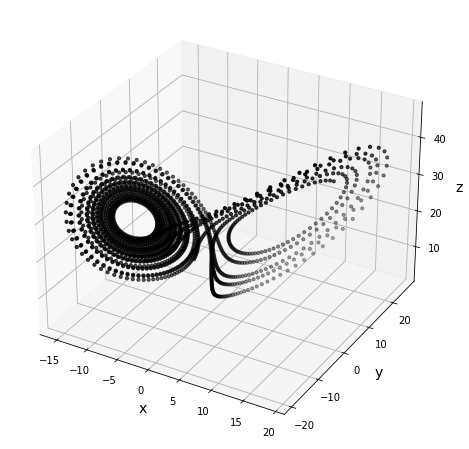

In [4]:
ps = 10
fs_label = 14
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2],s=ps,color='k')
ax.set_xlabel('x',fontsize=fs_label)
ax.set_ylabel('y',fontsize=fs_label)
ax.set_zlabel('z',fontsize=fs_label)
plt.savefig('%s/Input_pointcloud.png' % out_dir)

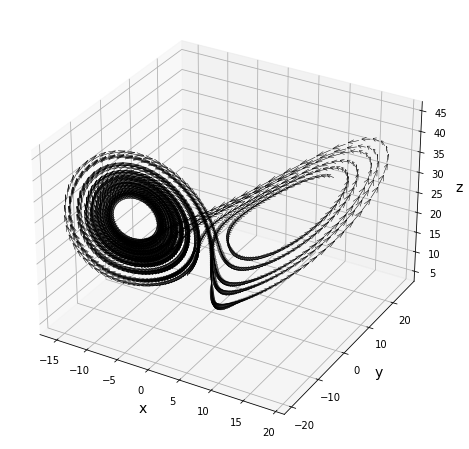

In [5]:
ps = 5
fs_label = 14
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.quiver(data[:, 0], data[:, 1], data[:, 2], data_vel[:, 0], data_vel[:, 1], data_vel[:, 2], length=3, normalize=True, arrow_length_ratio=0.5,linewidth=0.5,color='k')
ax.set_xlabel('x',fontsize=fs_label)
ax.set_ylabel('y',fontsize=fs_label)
ax.set_zlabel('z',fontsize=fs_label)
plt.savefig('%s/Input_velocity.png' % out_dir)

In [6]:
n,d = data.shape
data_out = np.empty([n+1,d+1],dtype=object)
data_out[0,1:] = np.array(['d%d' % (i+1) for i in range(d)])
data_out[1:,0] = np.array(['s%d' % (i+1) for i in range(n)])
data_out[1:,1:] = data
# np.savetxt('Lorentz.csv',data_out,delimiter=',',fmt='%s')
#
data_out = np.empty([n+1,d+1],dtype=object)
data_out[0,1:] = np.array(['d%d' % (i+1) for i in range(d)])
data_out[1:,0] = np.array(['s%d' % (i+1) for i in range(n)])
data_out[1:,1:] = data_vel
# np.savetxt('Lorentz_vel.csv',data_out,delimiter=',',fmt='%s')


In [7]:
def plot_vmapper_pca(mapper,data,data_vel,out_dir,out_file,fig_fmt='png'):
    n_node = mapper.num_node
    n_edge = int(
        0.5 * (np.sum(np.where(mapper.adjcy_mat > 0, 1, 0)) - n_node))
    data_node = np.empty([n_node, d], dtype=float)
    for i in range(n_node):
        data_node[i] = np.mean(data[mapper.node_id_set[i]], axis=0)

    data_node_pca = PCA(n_components=2).fit_transform(data_node)
    for i in [0,1]:
        if np.dot(data_node_pca[:,i],data_node[:,i]) < 0:
            data_node_pca[:,i] = -data_node_pca[:,i]
    #
    data_edge_pca = np.empty([n_edge, 4], dtype=float)
    edge_flow = np.zeros([n_edge], dtype=float)
    i_edge = 0
    for i in range(n_node):
        for j in range(i + 1, n_node):
            if mapper.adjcy_mat[i, j] > 0:
                idx_i = mapper.node_id_set[i]
                idx_j = mapper.node_id_set[j]
                idx_ij = np.intersect1d(idx_i, idx_j)
                mean_i = np.mean(data[idx_i], axis=0)
                mean_j = np.mean(data[idx_j], axis=0)
                rltv_vel = mean_j - mean_i
                edge_vel = np.mean(data_vel[idx_ij], axis=0)
                vel = np.dot(rltv_vel, edge_vel)
                if vel > 0:
                    data_edge_pca[i_edge, 0:2] = data_node_pca[i]
                    data_edge_pca[i_edge, 2:4] = data_node_pca[j] - data_node_pca[i]
                else:
                    data_edge_pca[i_edge, 0:2] = data_node_pca[j]
                    data_edge_pca[i_edge, 2:4] = data_node_pca[i] - data_node_pca[j]
                mean_vel = np.mean(data_vel[idx_ij], axis=0)
                flow = np.dot(mean_vel, rltv_vel) / np.linalg.norm(rltv_vel)
                edge_flow[i_edge] = flow
                i_edge += 1
    data_edge_pca = data_edge_pca[:i_edge]
    #
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(data_node_pca[:, 0], data_node_pca[:,
                1], zorder=1, s=5, color='gray')
    clim_min = np.percentile(edge_flow, 20)
    clim_max = np.percentile(edge_flow, 80)
    clim_delta = clim_max - clim_min
    ax.scatter(data_edge_pca[:, 0], data_edge_pca[:, 1],color='gray',zorder=0,s=50)
    ax.quiver(data_edge_pca[:, 0], data_edge_pca[:, 1], data_edge_pca[:, 2], data_edge_pca[:, 3], clim=(
        clim_min, clim_max), angles='xy', scale_units='xy', width=0.002, scale=1, alpha=0.8, zorder=10, headwidth=7, headlength=15, headaxislength=15)
    ax.axis('Off')
    plt.savefig('%s/%s.%s' % (out_dir,out_file,fig_fmt))
    plt.show()


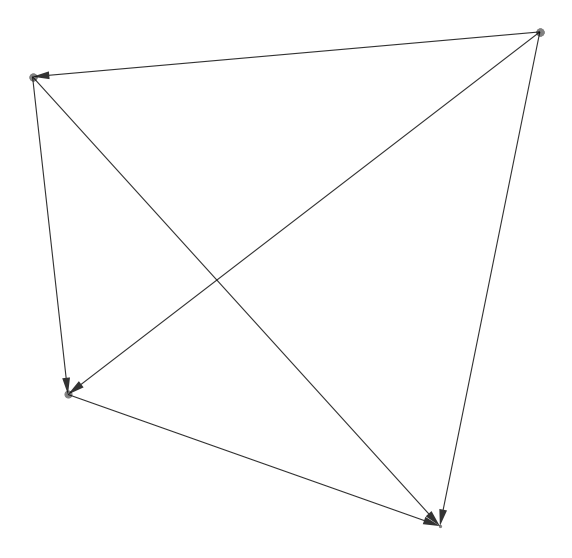

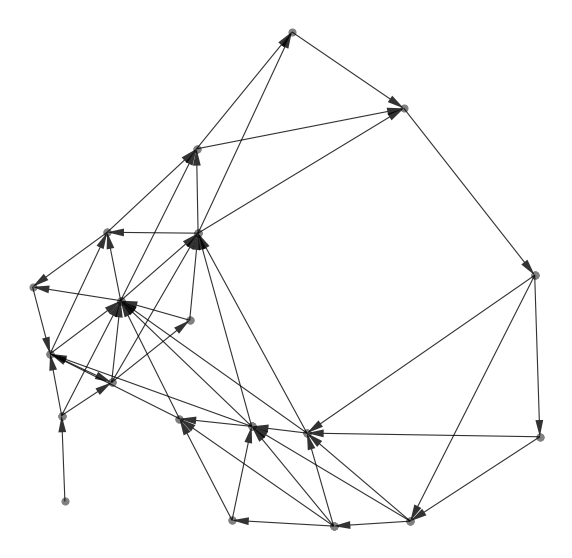

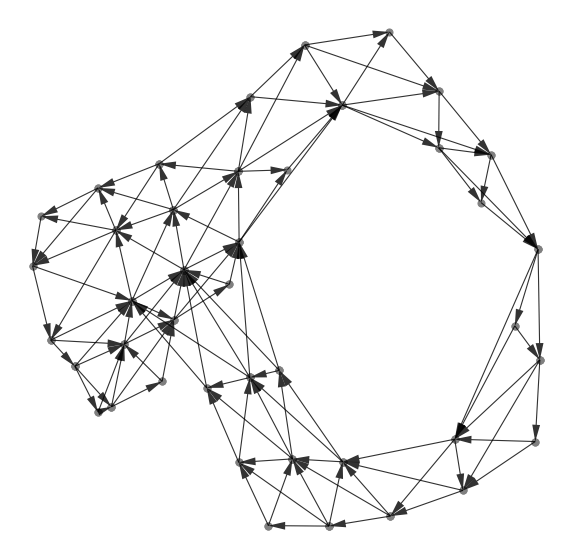

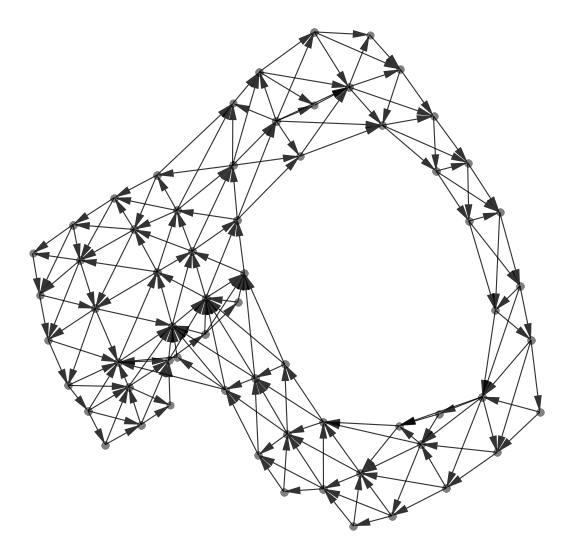

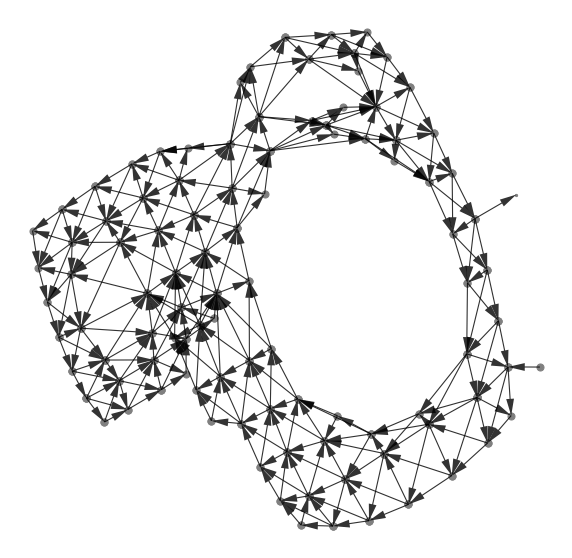

In [8]:
## V-Mapper with regular hypercube cover
clusterer = sklearn.cluster.DBSCAN(eps=3.0, min_samples=1)
adaptive=False

num_cube_list = [2,4,6,8,10]
for num_cube in num_cube_list:
    mapper = vmapper.mapper(
        data=data,
        data_p=data_p,
        num_cube=num_cube,
        overlap=0.5,
        clusterer=clusterer,
        adaptive=adaptive
    )
    out_file='mapper_Lorenz_vec_adpt%d_n%02d' % (int(adaptive),num_cube)

    plot_vmapper_pca(mapper,data,data_vel,out_dir,out_file)



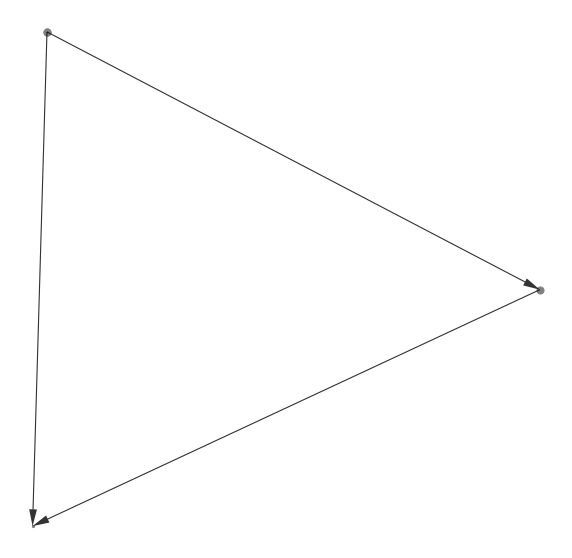

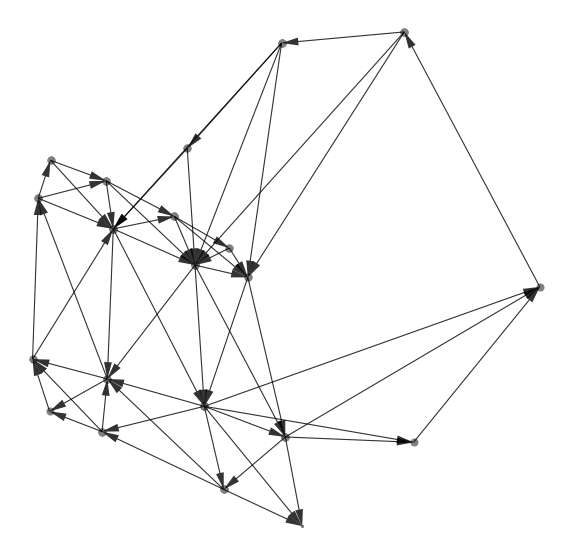

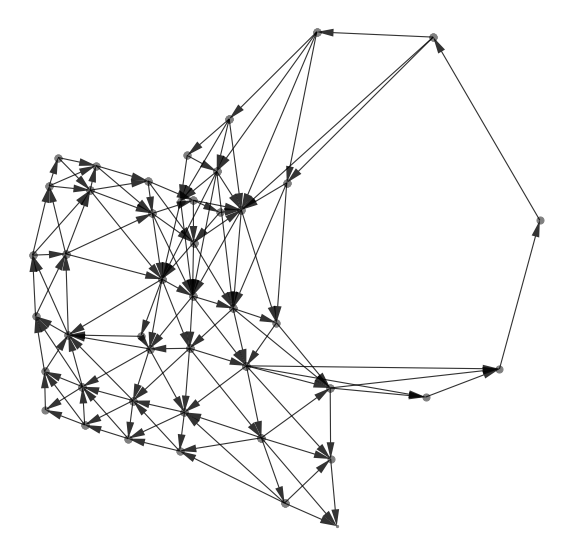

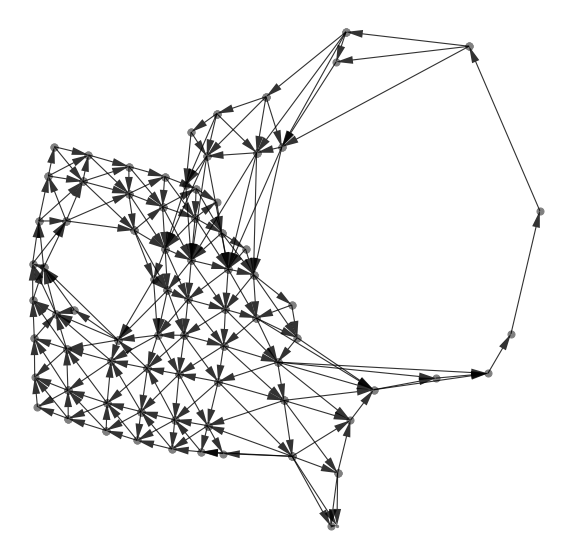

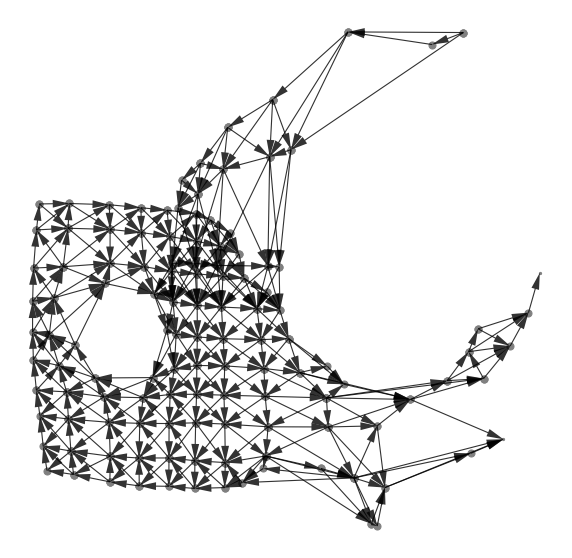

In [9]:
## V-Mapper with adaptive hypercube cover
adaptive=True
clusterer = sklearn.cluster.DBSCAN(eps=3.0, min_samples=1)
num_cube_list = [2,4,6,8,10]

for num_cube in num_cube_list:
    mapper = vmapper.mapper(
        data=data,
        data_p=data_p,
        num_cube=num_cube,
        overlap=0.5,
        clusterer=clusterer,
        adaptive=adaptive
    )
    out_file='mapper_Lorenz_vec_adpt%d_n%02d' % (int(adaptive),num_cube)

    plot_vmapper_pca(mapper,data,data_vel,out_dir,out_file)



In [33]:
## V-Mapper with regular hypercube cover
fig_fmt='png'
clusterer = sklearn.cluster.DBSCAN(eps=3.0, min_samples=1)
adaptive=False

from matplotlib.patches import Polygon

def plot_vmapper_pca_hom2d(mapper,data,data_vel,out_dir,out_file,fig_fmt='png'):
    n_node = mapper.num_node
    n_edge = int(
        0.5 * (np.sum(np.where(mapper.adjcy_mat > 0, 1, 0)) - n_node))
    data_node = np.empty([n_node, d], dtype=float)
    for i in range(n_node):
        data_node[i] = np.mean(data[mapper.node_id_set[i]], axis=0)

    data_node_pca = PCA(n_components=2).fit_transform(data_node)
    for i in [0,1]:
        if np.dot(data_node_pca[:,i],data_node[:,i]) < 0:
            data_node_pca[:,i] = -data_node_pca[:,i]
    #
    data_edge_pca = np.empty([n_edge, 4], dtype=float)
    edge_flow = np.zeros([n_edge], dtype=float)
    i_edge = 0
    for i in range(n_node):
        for j in range(i + 1, n_node):
            if mapper.adjcy_mat[i, j] > 0:
                idx_i = mapper.node_id_set[i]
                idx_j = mapper.node_id_set[j]
                idx_ij = np.intersect1d(idx_i, idx_j)
                mean_i = np.mean(data[idx_i], axis=0)
                mean_j = np.mean(data[idx_j], axis=0)
                rltv_vel = mean_j - mean_i
                edge_vel = np.mean(data_vel[idx_ij], axis=0)
                vel = np.dot(rltv_vel, edge_vel)
                if vel > 0:
                    data_edge_pca[i_edge, 0:2] = data_node_pca[i]
                    data_edge_pca[i_edge, 2:4] = data_node_pca[j] - data_node_pca[i]
                else:
                    data_edge_pca[i_edge, 0:2] = data_node_pca[j]
                    data_edge_pca[i_edge, 2:4] = data_node_pca[i] - data_node_pca[j]
                mean_vel = np.mean(data_vel[idx_ij], axis=0)
                flow = np.dot(mean_vel, rltv_vel) / np.linalg.norm(rltv_vel)
                edge_flow[i_edge] = flow
                i_edge += 1
    data_edge_pca = data_edge_pca[:i_edge]
    #
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(data_node_pca[:, 0], data_node_pca[:,
                1], zorder=1, s=5, color='gray')
    clim_min = np.percentile(edge_flow, 20)
    clim_max = np.percentile(edge_flow, 80)
    clim_delta = clim_max - clim_min
    ax.scatter(data_node_pca[:, 0], data_node_pca[:, 1],color='k',zorder=20,s=50)
    for i in range(n_node):
        for j in range(i + 1, n_node):
            if mapper.adjcy_mat[i, j] > 0:
                idx_ij = np.intersect1d(mapper.node_id_set[i],mapper.node_id_set[j])
                idx_i = mapper.node_id_set[i]
                idx_j = mapper.node_id_set[j]
                idx_ij = np.intersect1d(idx_i, idx_j)
                mean_i = np.mean(data[idx_i], axis=0)
                mean_j = np.mean(data[idx_j], axis=0)
                rltv_vel = mean_j - mean_i
                edge_vel = np.mean(data_vel[idx_ij], axis=0)
                vel = np.dot(rltv_vel, edge_vel)
                if vel > 0: plt_i,plt_j = i,j
                else: plt_i,plt_j = j,i
                ax.quiver(data_node_pca[plt_i, 0],data_node_pca[plt_i, 1],data_node_pca[plt_j, 0]-data_node_pca[plt_i, 0],data_node_pca[plt_j, 1]-data_node_pca[plt_i, 1],
                              color='k', angles='xy', scale_units='xy', width=0.002, scale=1, alpha=0.8, zorder=10, headwidth=7, headlength=15, headaxislength=15)
                # ax.plot([data_node_pca[i, 0],data_node_pca[j, 0]],[data_node_pca[i, 1],data_node_pca[j, 1]],color='blue',zorder=10,linewidth=1)
                for k in range(j + 1, n_node):
                    if len(np.intersect1d(idx_ij,mapper.node_id_set[k])) > 0:
                        p = Polygon([[data_node_pca[i, 0],data_node_pca[i, 1]],[data_node_pca[j, 0],data_node_pca[j, 1]],[data_node_pca[k, 0],data_node_pca[k, 1]]],
                                    closed=False,alpha=0.5,color='y',zorder=0)
                        ax.add_patch(p)
                    
    ax.axis('Off')
    plt.savefig('%s/%s.%s' % (out_dir,out_file,fig_fmt))
    plt.show()

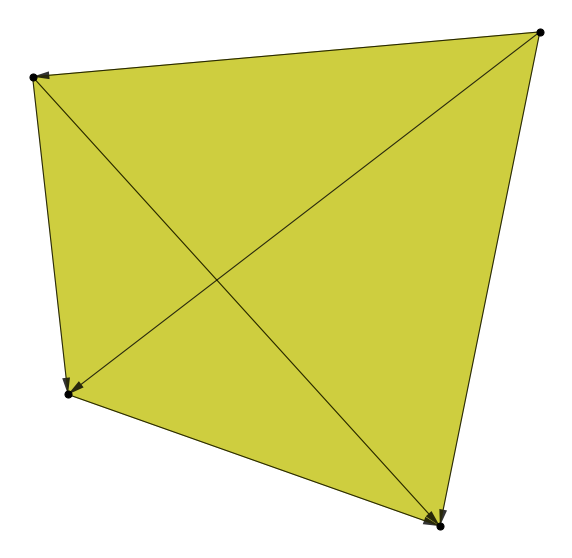

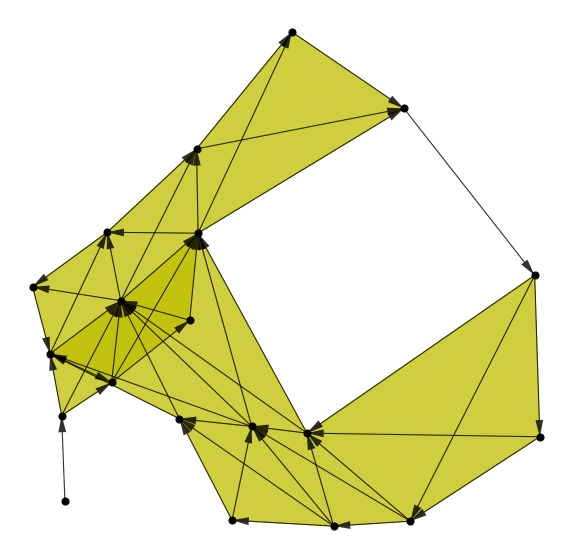

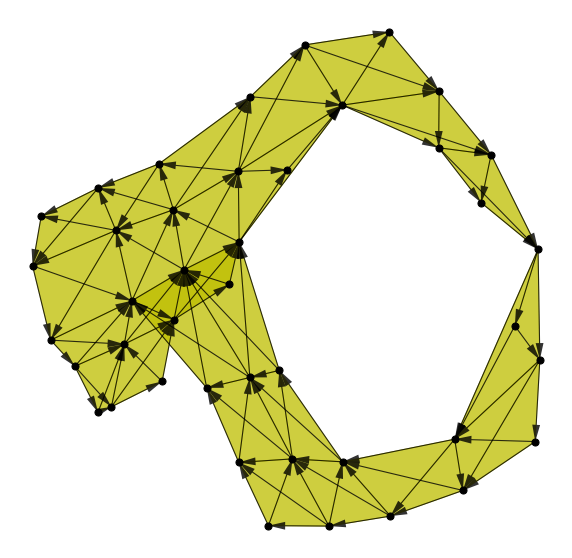

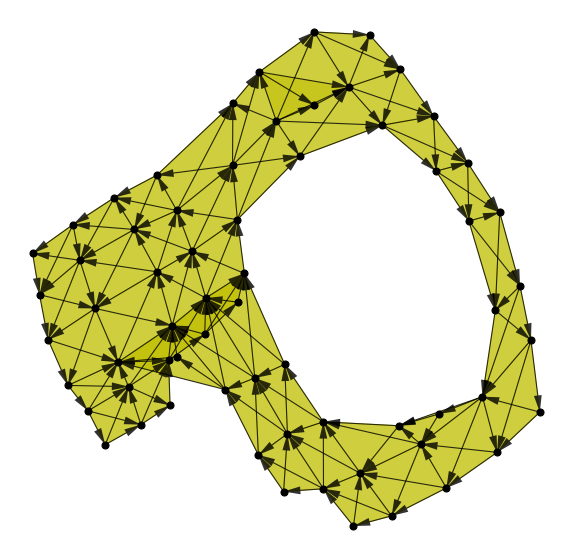

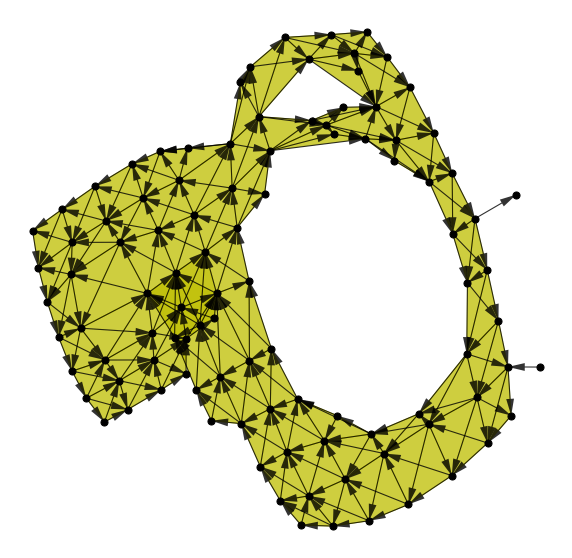

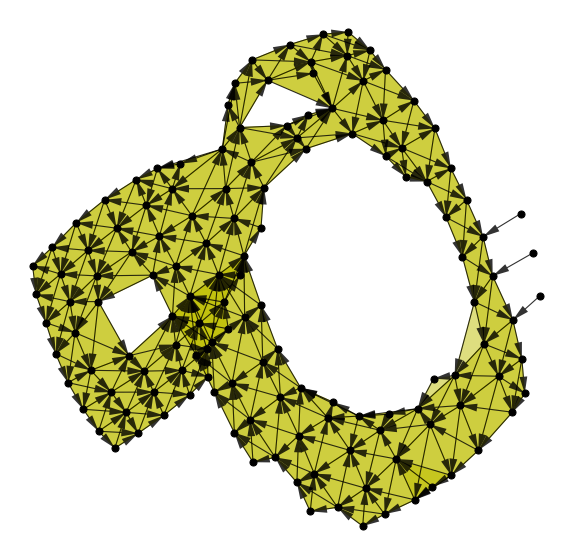

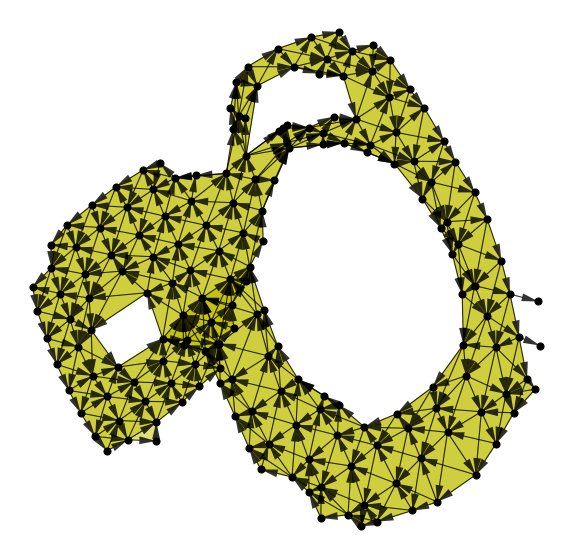

In [38]:
adaptive= False
num_cube_list = [2,4,6,8,10,12,14]
for num_cube in num_cube_list:
    mapper = vmapper.mapper(
        data=data,
            data_p=data_p,
        num_cube=num_cube,
        overlap=0.5,
        clusterer=clusterer,
        adaptive=adaptive
    )
    out_file='mapper_Lorenz_adpt%d_n%02d' % (int(adaptive),num_cube)

    plot_vmapper_pca_hom2d(mapper,data,data_vel,out_dir,out_file)

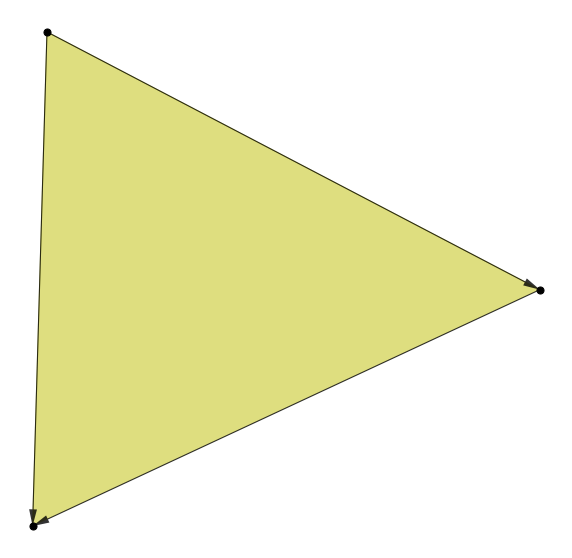

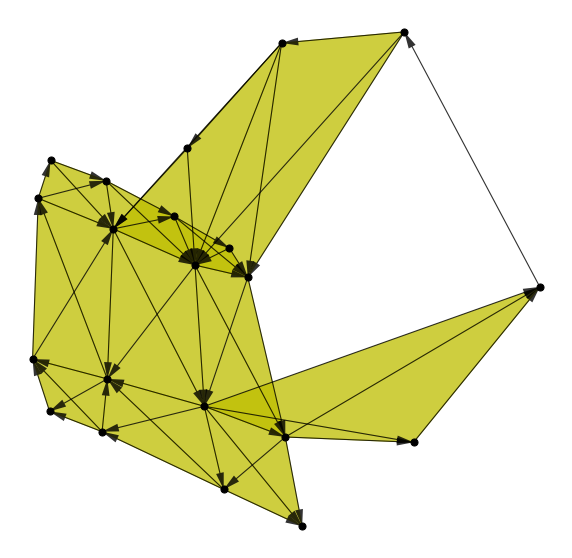

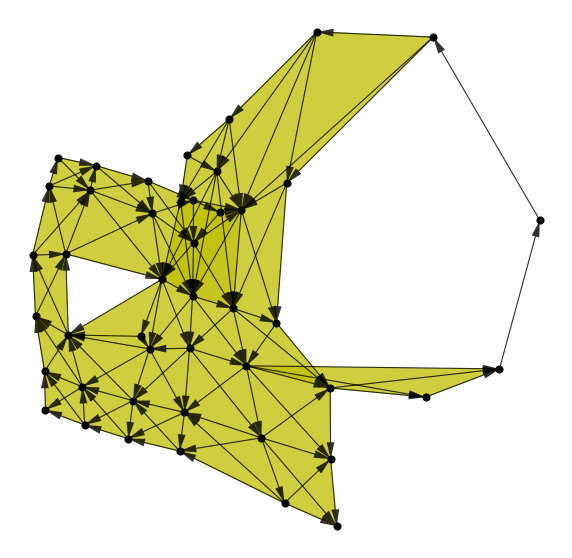

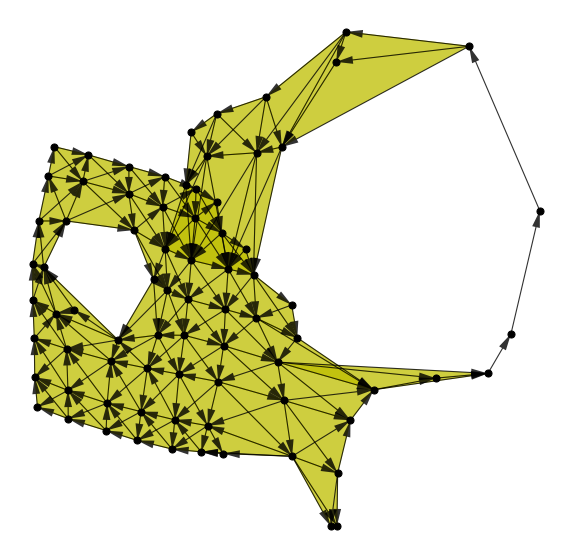

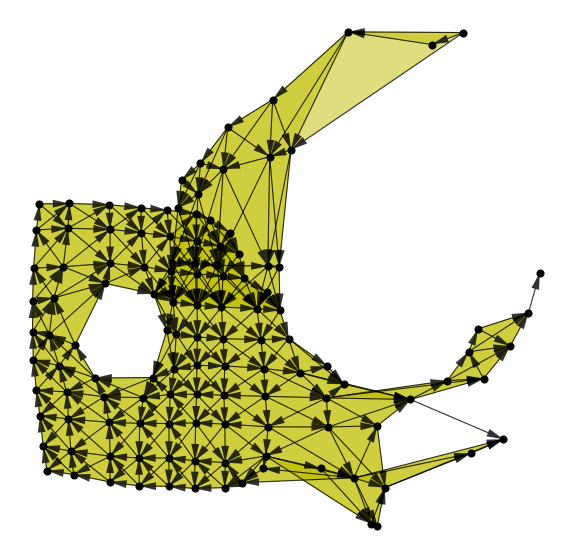

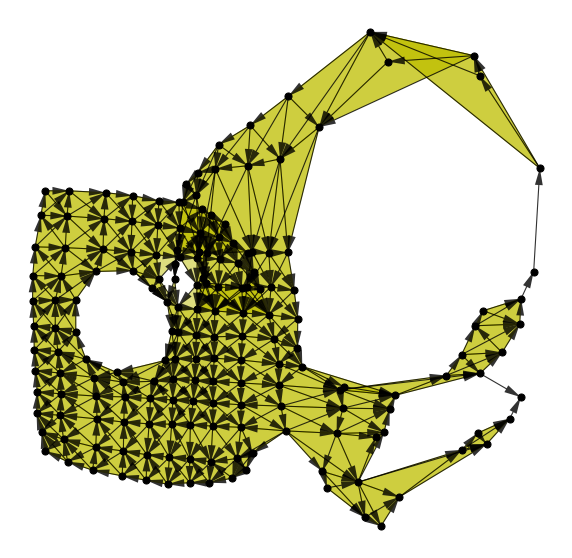

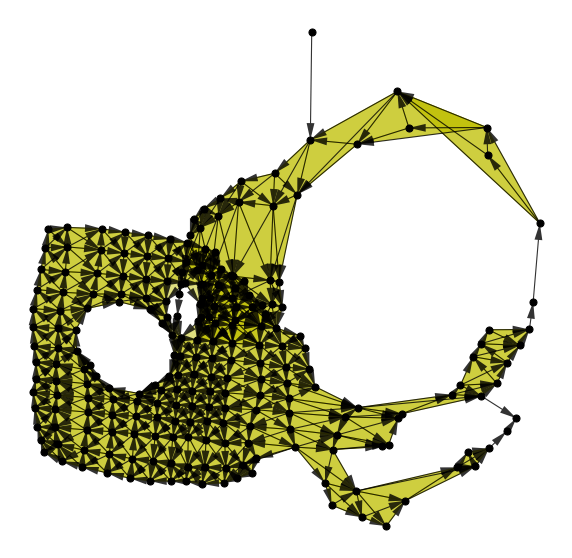

In [39]:
adaptive= True
num_cube_list = [2,4,6,8,10,12,14]
for num_cube in num_cube_list:
    mapper = vmapper.mapper(
        data=data,
        data_p=data_p,
        num_cube=num_cube,
        overlap=0.5,
        clusterer=clusterer,
        adaptive=adaptive
    )
    out_file='mapper_Lorenz_adpt%d_n%02d' % (int(adaptive),num_cube)

    plot_vmapper_pca_hom2d(mapper,data,data_vel,out_dir,out_file)